In [1]:
import os
import h5py
import mediapy as media
import matplotlib.pyplot as plt

def load_hdf5(dataset_path):
    if not os.path.isfile(dataset_path):
        print(f'Dataset does not exist at \n{dataset_path}\n')
        exit()

    with h5py.File(dataset_path, 'r') as root:
        qpos = root['/observations/qpos'][()]
        qvel = root['/observations/qvel'][()]
        image_dict = dict()
        for cam_name in root[f'/observations/images/'].keys():
            image_dict[cam_name] = root[f'/observations/images/{cam_name}'][()]
        action = root['/action'][()]

    return qpos, qvel, action, image_dict

In [2]:
# play cam video
data_file = '/home/aidara/augmented_imitation_learning/act_simplified/data/Cube_in_box/replay_2025-06-22_13-28-16.hdf5'
#data_file = 'data/demo/trained.hdf5'
qpos, qvel, action, image_dict = load_hdf5(dataset_path=data_file)

print(qpos[0])


[ 1.3583055   0.84196955 -1.0594712  -2.2785332  -0.21443543  3.5895705
 -1.3449194   0.02948776  0.02948776]


In [3]:
for cam_name, image_list in image_dict.items():
    media.show_video(image_list, fps=30)

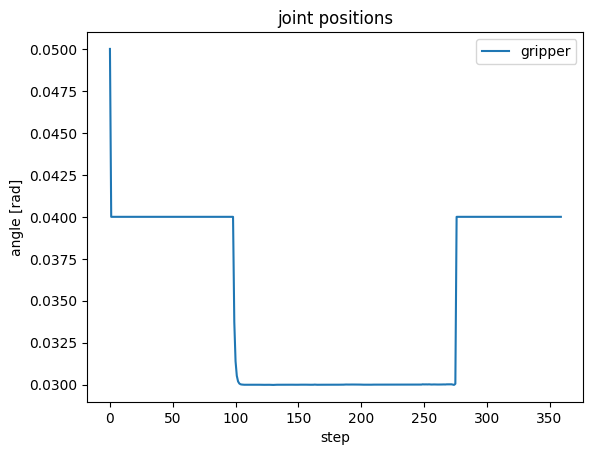

In [4]:
# plot qpos
plt.figure()
plt.plot(qpos[:, 7], label=["gripper"])
#plt.xlim((0,20))
plt.xlabel('step')
plt.ylabel('angle [rad]')
plt.title('joint positions')
plt.legend(loc='upper right')

plt.savefig('qpos.png')

In [ ]:
from franka_py import Robot, Gripper, PDController, set_default_behavior, move_to_joint_position

robot = Robot("192.168.1.200")
gripper = Gripper("192.168.1.200")
set_default_behavior(robot)

state = robot.read_once()
print(state.q)
print(qpos[0][:7])
move_to_joint_position(robot, qpos[0][:7].tolist(), 0.5)
gripper.homing()

: 

In [6]:
import numpy as np
import time
from franka_py import Controller

kp =  0.5*np.array([100, 100, 100, 100, 100, 100, 50])

pd_controller = Controller(robot, state.q,kp)

gripper_threshold = 0.035
frame_counter = 1


threshold_counter_open = 0
threshold_counter_close = 0
last_gripper_state = "open"

pd_controller.start()


for i,q in enumerate(qpos):
    q_joints = np.array(q[:7])
    
     ### Check if the targets are within joint limits and clip them
    low = np.array([-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, -0.0175, -2.8973]) 
    high = np.array([2.8973, 1.7628, 2.8973, -0.0698, 2.8973, 3.7525, 2.8973])
    safety_offset = 1e-2
    if np.any(np.isclose(q_joints, low, atol=safety_offset)) or np.any(np.isclose(q_joints, high, atol=safety_offset)):
        print("Warning: action is close to joint limit")
    q_joints = np.clip(q_joints, low + safety_offset, high - safety_offset)
    
    pd_controller.update_target(q_joints)
   
    print(f"Gripper joint: {q[8]} step {i}")    
    if q[8] > gripper_threshold:
        threshold_counter_open += 1
        threshold_counter_close = 0
    else:
        threshold_counter_close += 1
        threshold_counter_open = 0
        
    # Change gripper state after 3 consecutive frames in either direction
    if threshold_counter_open >= frame_counter and last_gripper_state != "open":
        gripper.move(0.08,1)
        last_gripper_state = "open"
        print("Opening gripper")
    elif threshold_counter_close >= frame_counter and last_gripper_state != "closed":
        gripper.grasp(0.0,0.5,70,0.5,0.5)

        last_gripper_state = "closed"
        print("Closing gripper")
    
    time.sleep(5/30)  
    
pd_controller.stop()

    
    

Gripper joint: 0.05000000074505806 step 0
Gripper joint: 0.039997514337301254 step 1
Gripper joint: 0.039995867758989334 step 2
Gripper joint: 0.039996419101953506 step 3
Gripper joint: 0.03999616950750351 step 4
Gripper joint: 0.0399966835975647 step 5
Gripper joint: 0.03999776393175125 step 6
Gripper joint: 0.0399976447224617 step 7
Gripper joint: 0.039998359978199005 step 8
Gripper joint: 0.0399986207485199 step 9
Gripper joint: 0.03999999910593033 step 10
Gripper joint: 0.03999999910593033 step 11
Gripper joint: 0.03999999910593033 step 12
Gripper joint: 0.03999999910593033 step 13
Gripper joint: 0.03999999910593033 step 14
Gripper joint: 0.03999999910593033 step 15
Gripper joint: 0.03999999910593033 step 16
Gripper joint: 0.03999999910593033 step 17
Gripper joint: 0.03999999910593033 step 18
Gripper joint: 0.03999999910593033 step 19
Gripper joint: 0.03999999910593033 step 20
Gripper joint: 0.03999999910593033 step 21
Gripper joint: 0.03999999910593033 step 22
Gripper joint: 0.039

KeyboardInterrupt: 

In [ ]:
for i,q in enumerate(qpos):
    before_q = robot.read_once()
    print(f"Before q: {before_q.q}")
    print(f"Target q: {q[:7]}")
    print(f"Difference: {np.linalg.norm(before_q.q - q[:7])}")
    print(f"The maximum difference is {np.max(np.abs(before_q.q - q[:7]))}")
    print(f"At the joint: {np.argmax(np.abs(before_q.q - q[:7]))}")
    q[5,]
    move_to_joint_position(robot, q[:7].tolist(), 0.1)
    curr_q = robot.read_once()
    if np.linalg.norm(curr_q.q - q[:7]) > 0.001:
        print(f"The robot has not reached the goal yet. This is the error: {np.linalg.norm(curr_q.q - q[:7])}")
        print("Stopping robot")
        move_to_joint_position(robot, q[:7].tolist(), 1)
        
    while np.linalg.norm(curr_q.dq) > 0.01:
        time.sleep(0.1)
        curr_q = robot.read_once()
        print(f"Current dq: {curr_q.dq}")
        print("Waiting for robot to stop")
        
        
    print(f"Step {i} done")
    if i > 10:
        break
robot.stop()
